In [355]:
import numpy as np
import matplotlib.pyplot as plt
from math import factorial

In [356]:
#Only needed for Tutorial, for the analytic solution
def Hermitian(N, X):
    if N == 0:
        return 1
    Hn = np.zeros(N+1)
    if isinstance(X, int):
        Hn[0] = 1
        Hn[1] = 2*X
        if N == 1:
            return Hn[1] 
        for i in range(2,len(Hn)):
            Hn[i] = 2*X*Hn[i-1]-2*(i-1)*Hn[i-2]
        return Hn[-1]
    else:
        HN = []
        for x in X:
            Hn[0] = 1
            Hn[1] = 2*x
            if N == 1:
                return Hn[1] 
            for i in range(2,len(Hn)):
                Hn[i] = 2*x*Hn[i-1]-2*(i-1)*Hn[i-2]
            HN.append(Hn[i])
        
    return HN

In [377]:

#Calculates each step using numerow method
def numerow_step(psi_minus_1, psi, k_minus_1, k, k_plus_1, h):
    h2 = h ** 2
    a = 2 * (1 - (5 / 12) * (h2) * k) * psi
    b = (1 + (1 / 12) * (h2) * k_minus_1) * psi_minus_1
    c = (1 + (1 / 12) * (h2) * k_plus_1)
    return (a - b) / c

#Calculates K for Numerow (epsilon-x^2)
def k(n, x):
    return 2 * (n + (1 / 2)) - x ** 2

#Does Calculation
def Numerow(a, k, h, xmax, n, extrapolateintominus=True):
    #initiate starting values
    x0 = 0
    x_out = [x0]
    #Needed to check for antisymmetry or symmetry
    if n%2 == 1:
        psi0 = 0
        psi1 = a
    else:  
        psi0 = a
        psi1 = psi0 - h ** 2 * k(n, x0) * psi0 / 2
    psi_out = [psi0, psi1]
    x0 += h
    x_out.append(x0)
    #claculate over intervall
    while x0 <= xmax:
        x0 += h
        psin = numerow_step(psi_out[-2], psi_out[-1], k(n, (x_out[-2])), k(n, (x_out[-1])), k(n, (x0)), h)
        #Needed for plotting
        psi_out.append(psin)
        x_out.append(x0)
    #Turn into arrays
    x_out = np.array(x_out)
    if extrapolateintominus:
        #turn arrays e.g from (0, 1, ... , 9, 10) into (-10, -9, ... , 9, 10)
        x_out = np.array([*(-1 * x_out[:1:-1]), *x_out])
        psi_out = np.array(psi_out)
        #Used to extrapolate calculated values for (anti)symmetry into negative values, same scheme as above
        if (n % 2 == 1):
            psi_out = np.array([*(-1 * psi_out[:1:-1]), *psi_out])
        else:
            psi_out = np.array([*(psi_out[:1:-1]), *psi_out])
    return x_out, psi_out


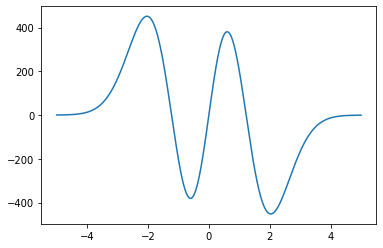

In [378]:
x_out, YG = Numerow(1, k, 0.001, 5, 3)
plt.plot(x_out, YG)

In [372]:
def psi_ana(x0, xmax, N,n):
    x, stepsize = np.linspace(x0,xmax,N+1,retstep=True)
    return (Hermitian(n, x))/np.sqrt(factorial(2**n)*np.sqrt(np.pi))*np.e**(-(x**2)/2), x

In [373]:
psi_Ana, x = psi_ana(-10, 10, 1000, 6)

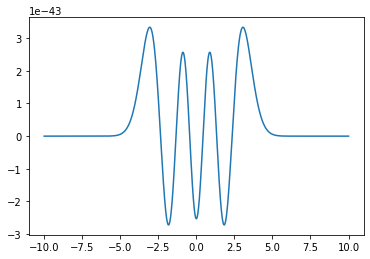

In [374]:
plt.plot(x, psi_Ana)

In [375]:
def kb(epsilon, x):
    return epsilon-x



def numerow(a, k, h, xmax, epsilon):
    #initiate starting values
    x0 = 0
    x_out = [x0]
    psi0 = 0
    psi1 = a
    psi_out = [psi0, psi1]
    x0 += h
    x_out.append(x0)
    #iterate over intervall
    while x0 <= xmax:
        x0 += h
        #calculate using numerow method
        psin = numerow_step(psi_out[-2], psi_out[-1], kb(epsilon, (x_out[-2])), kb(epsilon, (x_out[-1])), kb(epsilon, (x0)), h)
        #Needed for plotting
        psi_out.append(psin)
        x_out.append(x0)
    #convert into arrays
    x_out = np.array(x_out)
    psi_out = np.array(psi_out)
    return x_out, psi_out

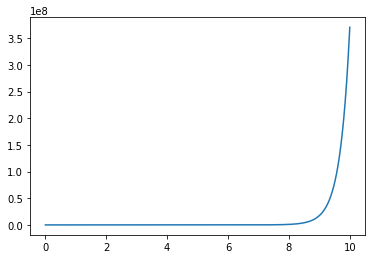

In [379]:
x_out, psi = Numerow(1, kb, 0.001, 10, 0.001, extrapolateintominus=False)
plt.plot(x_out, psi)

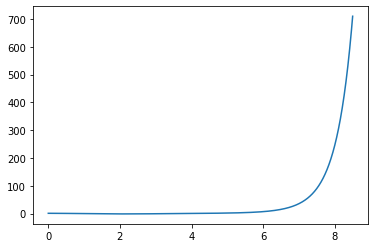

In [380]:
x_out, psi = Numerow(1, kb, 0.001, 8.5, 3.5, extrapolateintominus=False)
plt.plot(x_out, psi)

In [365]:
def find_eigenvalues(steps, stepsize):
    #Stores possible solutions
    poss_sol = []
    #Stores last value of each calculation
    list_last = []
    #calculate for different epsilons
    for i in range(steps):
        x, y = Numerow(1, kb, 0.001, 10, i*stepsize)
        list_last.append(y[-1])
    #turn into np.array
    list_last = np.array(list_last)
    #Iterate over every list item
    for n, y in enumerate(list_last):
        #Dont check 1st item, error would be thrown
        if n == 0:
            pass
        #if the last value of the array switches its value from plus to minus,
        # we know one of the values for epsilon must be an eigenvalue 
        elif list_last[n-1] > 0 and list_last[n] < 0:
            #checks which value is closer to zero and appends the one to the solutions list
            if abs(list_last[n-1]) < abs(list_last[n]):
                poss_sol.append((n-1)*stepsize)
            else:
                poss_sol.append(n*stepsize)
        #vice versa for switch form minus to plus
        elif list_last[n-1] < 0 and list_last[n] > 0:
            #same as above
            if abs(list_last[n-1]) < abs(list_last[n]):
                poss_sol.append((n-1)*stepsize)
            else:
                poss_sol.append(n*stepsize)
        #break after 3 solutions are found
        if len(poss_sol) == 3:
            break
        
    return poss_sol
    

In [366]:
poss_sol = find_eigenvalues(1000, 0.01)

In [367]:
print(poss_sol)

[1.02, 3.25, 4.82]


In [368]:
#Calculate all values
x_out_0, psi_0 = numerow(1, kb, 0.1, 8, poss_sol[0])
x_out_1, psi_1 = numerow(1, kb, 0.01, 8, poss_sol[1])
x_out_2, psi_2 = numerow(1, kb, 0.01, 8, poss_sol[2])


#The following is needed to cut off the plot, so it looks nice
for n, y in enumerate(psi_0):
    #Looks, when psi == 0, then cuts off the array
    if y < 0 and n>5:
        psi_0 = psi_0[:n]
        x_out_0 = x_out_0[:n]
        break



for m, psi_n in enumerate(psi_1):
    #Looks, when psi_1 is greater than 0 and psi_0 is smaller than 0
    #then cuts off the array
    if psi_n > 0 and psi_1[m-1] < 0:
        psi_1 = psi_1[:m]
        x_out_1 = x_out_1[:m]
        break


for n, y in enumerate(psi_2):
    counter = 0
    if y > 0 and n<1:
        #Looks, when psi == 0, for the third time, then cuts off the array
        if counter == 2:
            psi_2 = psi_2[:n]
            x_out_2 = x_out_2[:n]
            break
        counter +=1

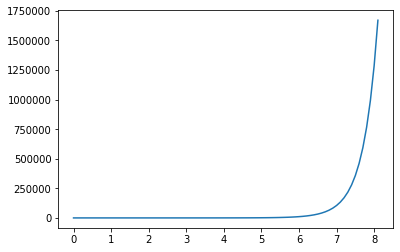

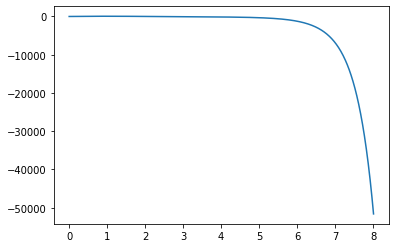

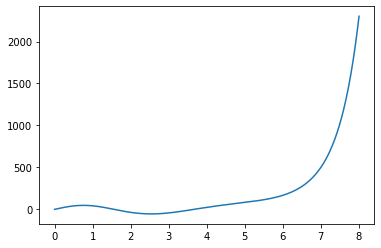

In [369]:
figure = plt.figure()
plt.plot(x_out_0, psi_0)
fig = plt.figure()
plt.plot(x_out_1, psi_1)
fig = plt.figure()
plt.plot(x_out_2, psi_2)